# Тетрадка содержит код исследования количества банкоматов, которые придется ежедневно обслуживать, если в предыдущий день обслужили все, которые переполнятся через n дней или у которых через n дней окажется больше 2 недель с момента последней инкассации

Данные для моделирования 

    - величина % в годовых, которую банк платит за неинкассированную сумму денег в терминале - 2 (т.е. сумма за день = остаток * 2/100/365);
    - стоимость обслуживания одного терминала в случае его инкассирования = 0,01% от суммы инкассации, но не менее 100 рублей (т.е. для суммы 50000 = 100, для суммы 1500000 = 150);
    - максимально допустимая сумма денег в терминале - 1000000;
    - максимально допустимое время, в течение которого терминал можно не обслуживать - 14 дней;
    - стоимость одного броневика на день - 20000;
    - начало и конец рабочего дня броневиков - c 08:00 по 20:00 мск. времени;
    - время простоя броневика на точке (время на инкассирование) - 10 минут


Возьмём терминал 406136: 
На утро 01.09 остаток = 160000.

Если его обслужить 01.09 и забрать 160000, то остаток на вечер будет = 0, платить за фондирование 01.09 не надо. Но будут издержки = 100 руб. за обслуживание.
1.1. На утро 02.09 остаток станет = 90000. Добавятся 90000 из оборотов 01.09. 

Если его не обслужить 01.09, то на вечер 01.09 остаток будет = 160000 и 01.09 у вас возникают издержки, связанные с фондированием = 7.45. Издержек за обслуживание не будет.
2.1. На утро 02.09 остаток станет = 250000 (160000 + 90000 поступлений за 01.09).
	2.1.1. Если 02.09 обслужить терминал, то остаток на вечер = 0. Фондирование = 0. Издержки за обслуживание = 100.
	2.1.2. Если 02.09 не обслуживать терминал, то остаток на вечер = 250000. Фондирование = 13.70. Издержки за обслуживание = 0.


In [1]:
from typing import List, Tuple, Optional, Dict
from warnings import warn

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from bank_schedule.ortools_tsp import solve_tsp_ortools

from bank_schedule.data import Data, distances_matrix_from_dataframe
from bank_schedule.helpers  import calc_cartesian_coords
from bank_schedule import forecast, helpers, cluster, scheduler, ortools_tsp
from bank_schedule import plot as bsplot
from bank_schedule.constants import RAW_DATA_FOLDER, INTERIM_DATA_FOLDER


In [2]:
def split_oneroute(route: List[int],
                   route_time: List[float],
                   max_route_time: float):
    """_summary_

    Args:
        route (List[int]): _description_
        route_time (List[float]): _description_
        max_route_time (float): _description_
    """
    pass


def line_route_to_points_pairs(route: List[int]) -> List[Tuple[int, int]]:
    """Преобразует маршрут в массивов точеепар из двоездов

    Args:
        route (List[int]): _description_

    Returns:
        List[Tuple[int, int]]: _description_
    """
    pairs = []
    for i in range(len(route) - 1):
        pairs.append((route[i], route[i + 1]))
    return pairs


In [3]:
loader = Data(RAW_DATA_FOLDER)
distances_df = loader.get_distance_matrix()
geo_df = loader.get_geo_TIDS()
incomes_df = loader.get_money_in()

initial_residuals = scheduler.get_initial_resuduals(loader,
                                                    last_collection_equal_to_initial=True)

In [4]:
route = [683103, 634763, 636538]
nearest = scheduler.get_neighbours(route, loader, radius=20)

to_plot = geo_df.loc[geo_df['TID'].isin(nearest + route), :].copy()
to_plot['main_pair'] = to_plot['TID'].isin(route)

bsplot.geoplot_clusters(to_plot, 'main_pair', html_folder=INTERIM_DATA_FOLDER)

In [5]:
# Оценим теоретически достижимое максимальное число точек,
# которое может обслужить одна машина за день
sort_dist = distances_df.sort_values(by='Total_Time')

# прибавляем ко времени пути время на инкассацию
sort_dist['Total_Time'] += 10

# считаем куммулятивную сумму так, как будто все близкие точки попали в один кластер
# и мы их последовательно инкассируем
sort_dist['cumsum_time'] = sort_dist['Total_Time'].cumsum()

# смотрим, сколько точек мы успели объехать
max_tids = sort_dist[sort_dist['cumsum_time'] < 12 * 60].shape[0]
print('Максимальное теоретически достижимое число точек на 1 машину:', max_tids)

Максимальное теоретически достижимое число точек на 1 машину: 70


In [6]:
hist_mdl = forecast.ForecastHistorical()
lgbm_mdl = forecast.IncomeForecastLGBM()

Настроим параметры шедулера на исторических данных так, чтобы не было скачков в количестве банкоматов, которые надо обслужить обязательно в текущий день

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning:

Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/scheduler.py:351: UserWarning:

Банкоматов, обязательных для обслуживания - 162 (> 160). Будут инкассироваться только они, соседние не добавляем.



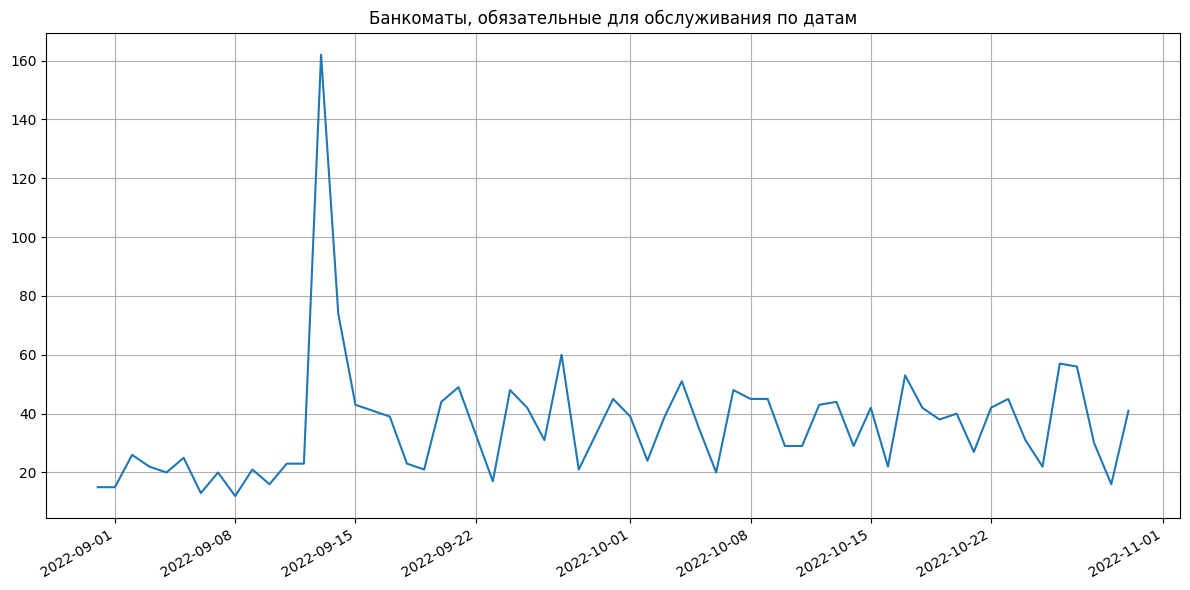

In [8]:
horizon = 14
deadline_thresh = 1
atms_per_day = 160
neighborhood_radius = 10
use_greedy = True

residuals = initial_residuals.copy()
today = scheduler.get_today_from_residuals(residuals)

end_date = pd.to_datetime('2022-10-31')

dates_list, n_mandatory_atms_list = [], []

while today < end_date:
    dates_list.append(today)
    tomorrow = today + pd.Timedelta(days=1)
    residuals = scheduler.prepare_residual_to_schedule_creation(residuals, lgbm_mdl, horizon=horizon)
    atms_for_today_collection = scheduler.get_atms_for_today_collection(loader,
                                                                        residuals,
                                                                        n_samples=atms_per_day,
                                                                        mandatory_selection_threshold=deadline_thresh,
                                                                        neighborhood_radius=neighborhood_radius,
                                                                        use_greedy=use_greedy)


    n_mandatory_atms = atms_for_today_collection['is_mandatory'].sum()
    n_mandatory_atms_list.append(n_mandatory_atms)
    collected_tids = atms_for_today_collection['TID'].to_list()

    # обнуляем остатки и дату в инкассированных банкоматах
    collected_cond = residuals['TID'].isin(collected_tids)
    residuals['date'] = tomorrow
    residuals.loc[collected_cond, 'money'] = 0
    residuals.loc[collected_cond, 'last_collection_date'] = tomorrow
    residuals.loc[collected_cond, 'overflow_date'] = pd.NaT

    # считаем остаток на вечер дня инкассации, зная income за этот день
    resid_money = residuals.set_index('TID')['money']
    income_money = incomes_df.set_index('TID')
    income_money = income_money.loc[income_money['date']==tomorrow, 'money_in']
    income_money = income_money[resid_money.index]

    residuals['money'] = (resid_money + income_money).values

    today = tomorrow

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=n_mandatory_atms_list, index=dates_list))
plt.title('Банкоматы, обязательные для обслуживания по датам')
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()

In [9]:
n_iterations = 1
max_route_time = 720

residuals = initial_residuals.copy()

today = scheduler.get_today_from_residuals(residuals)

end_date = pd.to_datetime('2022-11-30')
dates, routes, routes_times, n_cars, n_atms = [], [], [], [], []

while today < end_date:
    dates.append(today)
    tomorrow = today + pd.Timedelta(days=1)
    residuals = scheduler.prepare_residual_to_schedule_creation(residuals, lgbm_mdl, horizon=horizon)

    day_routes, day_routes_times, day_n_cars = ortools_tsp.optimize_routes(
        loader,
        residuals,
        atms_per_day=atms_per_day,
        mandatory_selection_threshold=deadline_thresh,
        n_iterations=n_iterations,
        neighborhood_radius=neighborhood_radius,
        max_route_time=max_route_time,
        mandatory_selection_col='days_to_deadline',
        tids_col='TID',
        use_greedy=use_greedy
        )

    n_cars.append(day_n_cars)
    routes.append(day_routes)
    routes_times.append(day_routes_times)

    print(today, len(day_routes), day_n_cars)

    n_atms.append( len(day_routes) )

    # обнуляем остатки и дату в инкассированных банкоматах
    collected_cond = residuals['TID'].isin(day_routes)
    residuals['date'] = tomorrow
    residuals.loc[collected_cond, 'money'] = 0
    residuals.loc[collected_cond, 'last_collection_date'] = tomorrow
    residuals.loc[collected_cond, 'overflow_date'] = pd.NaT

    # считаем остаток на вечер дня инкассации, зная income за этот день
    resid_money = residuals.set_index('TID')['money']
    income_money = incomes_df.set_index('TID')
    income_money = income_money.loc[income_money['date']==tomorrow, 'money_in']
    income_money = income_money[resid_money.index]

    residuals['money'] = (resid_money + income_money).values

    today = tomorrow

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning:

Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID



2022-08-31 00:00:00 160 5.55544444444445
2022-09-01 00:00:00 160 5.851833333333334
2022-09-02 00:00:00 160 5.85498611111111
2022-09-03 00:00:00 160 5.468708333333336
2022-09-04 00:00:00 160 6.074833333333331
2022-09-05 00:00:00 160 5.352930555555555
2022-09-06 00:00:00 160 5.697416666666668
2022-09-07 00:00:00 160 5.579430555555557
2022-09-08 00:00:00 160 5.7238194444444455
2022-09-09 00:00:00 160 5.401208333333335
2022-09-10 00:00:00 160 5.935444444444445
2022-09-11 00:00:00 160 5.600666666666663
2022-09-12 00:00:00 160 5.955958333333334


/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/scheduler.py:351: UserWarning:

Банкоматов, обязательных для обслуживания - 162 (> 160). Будут инкассироваться только они, соседние не добавляем.



2022-09-13 00:00:00 162 5.985708333333339
2022-09-14 00:00:00 160 5.567986111111113
2022-09-15 00:00:00 160 5.688944444444444
2022-09-16 00:00:00 160 5.555444444444445
2022-09-17 00:00:00 160 5.427902777777776
2022-09-18 00:00:00 160 5.72948611111111
2022-09-19 00:00:00 160 5.506208333333332
2022-09-20 00:00:00 160 5.703972222222223
2022-09-21 00:00:00 160 5.6587361111111125
2022-09-22 00:00:00 160 5.718250000000002
2022-09-23 00:00:00 160 5.879791666666668
2022-09-24 00:00:00 160 5.809277777777777
2022-09-25 00:00:00 160 5.447
2022-09-26 00:00:00 160 6.138916666666666
2022-09-27 00:00:00 160 5.7247499999999985
2022-09-28 00:00:00 160 6.0708472222222225
2022-09-29 00:00:00 160 5.453083333333334
2022-09-30 00:00:00 160 5.749736111111112
2022-10-01 00:00:00 160 5.528319444444445
2022-10-02 00:00:00 160 5.479624999999999
2022-10-03 00:00:00 160 5.7110833333333355
2022-10-04 00:00:00 160 5.799291666666665
2022-10-05 00:00:00 160 5.649083333333333
2022-10-06 00:00:00 160 6.091027777777777
2

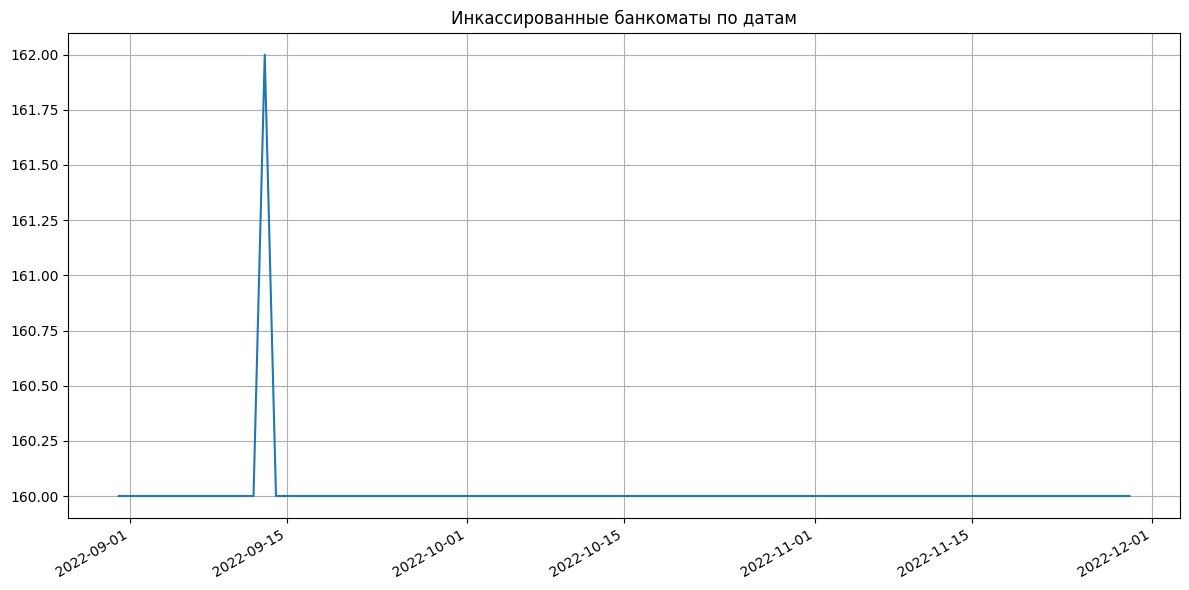

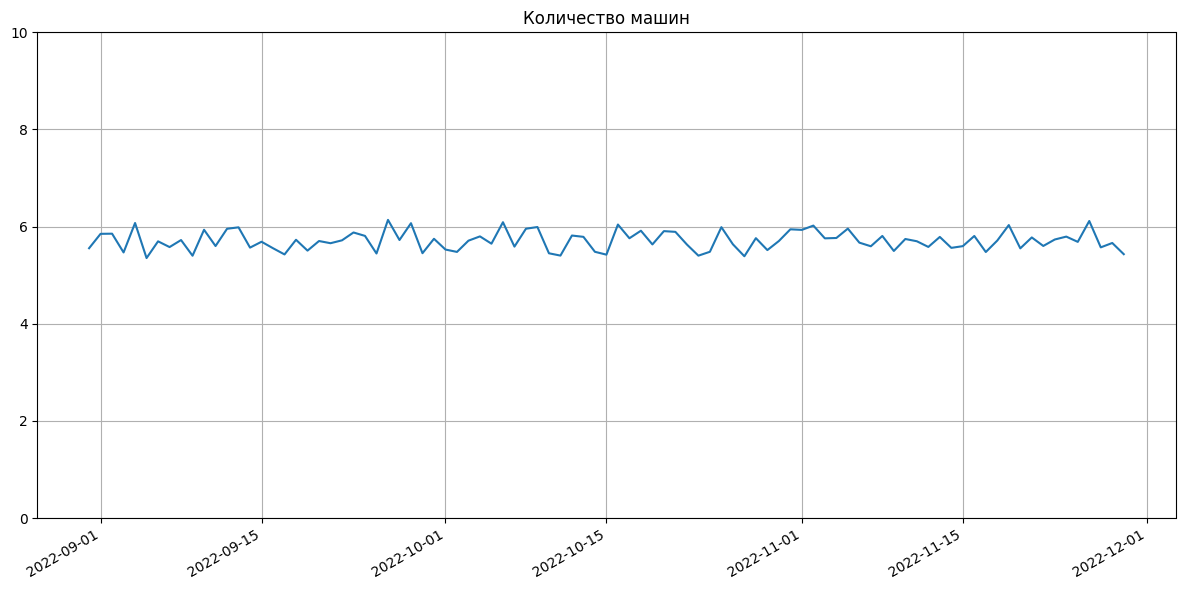

In [10]:
routes_series = pd.Series(index=dates, data=n_atms)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=routes_series, index=dates))
plt.title('Инкассированные банкоматы по датам')
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()

cars_series = pd.Series(index=dates, data=n_cars)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=cars_series, index=dates))
plt.title('Количество машин')
fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0,10)
plt.grid()
plt.show()

In [11]:
day = 1
geoplot_df = geo_df.copy()
geoplot_df['was_collected'] = geoplot_df.index.isin(day_routes_times[day])
bsplot.geoplot_clusters(geoplot_df,
                        'was_collected')

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [float]

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Scattergeo(
#     locationmode = 'USA-states',
#     lon = df_airports['long'],
#     lat = df_airports['lat'],
#     hoverinfo = 'text',
#     text = df_airports['airport'],
#     mode = 'markers',
#     marker = dict(
#         size = 2,
#         color = 'rgb(255, 0, 0)',
#         line = dict(
#             width = 3,
#             color = 'rgba(68, 68, 68, 0)'
#         )
#     )))

# lons = []
# lats = []
# import numpy as np
# lons = np.empty(3 * len(df_flight_paths))
# lons[::3] = df_flight_paths['start_lon']
# lons[1::3] = df_flight_paths['end_lon']
# lons[2::3] = None
# lats = np.empty(3 * len(df_flight_paths))
# lats[::3] = df_flight_paths['start_lat']
# lats[1::3] = df_flight_paths['end_lat']
# lats[2::3] = None

# fig.add_trace(
#     go.Scattergeo(
#         locationmode = 'USA-states',
#         lon = lons,
#         lat = lats,
#         mode = 'lines',
#         line = dict(width = 1,color = 'red'),
#         opacity = 0.5
#     )
# )

# fig.update_layout(
#     title_text = 'Feb. 2011 American Airline flight paths<br>(Hover for airport names)',
#     showlegend = False,
#     geo = go.layout.Geo(
#         scope = 'north america',
#         projection_type = 'azimuthal equal area',
#         showland = True,
#         landcolor = 'rgb(243, 243, 243)',
#         countrycolor = 'rgb(204, 204, 204)',
#     ),
#     height=700,
# )

# fig.show()